# Preparação e Exploração de Taxa de Câmbio 

Aqui é explorada a série temporal de taxa de intercâmbio entre YAN (moeda japonesa) e USD (dólar americano), sendo tratados: 
- Valores omissos (imputação/ interpolação)
- Mudança de escala temporal (diária -> mensal) para posterior combinação com outras séries temporais
## Importação e Exploração de Dados

Os dados são obtidos do FRED(Federal Reserve Economic Data) e a frequência temporal é explicitada como Business Days, através da letra B.

In [73]:
import pandas as pd 
import numpy as np 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime 

# seasonal_decompose from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Name id to get data
dataset = 'DEXJPUS'
start = datetime(2013,3, 1)
end = datetime(2023,3, 1)

exchange = web.DataReader(dataset, data_source = 'fred', start=start, end=end)
exchange.index.freq = 'B'
exchange.head(5)

,DEXJPUS
DATE,
2013-03-01,93.38
2013-03-04,93.32
2013-03-05,93.39
2013-03-06,93.64
2013-03-07,95.00


### Verificar valores nulos

Neste passo, confirma-se a utilização das datas como objeto DateTime, com frequência B (Business Days) e verifica-se a existência de valores nulos.

In [58]:
exchange = exchange.rename(columns={'DEXJPUS': 'Rate'})
exchange.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2609 entries, 2013-03-01 to 2023-03-01
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    2499 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB


### Visualização da Série Temporal

Neste passo, é representada a série temporal, para ver o seu comportamento. 
Não é aparente, uma tendência fixa ou a existência de sazonalidade.

Text(0.5, 1.0, 'Japanese Yen to U.S. Dollar Spot Exchange Rate')

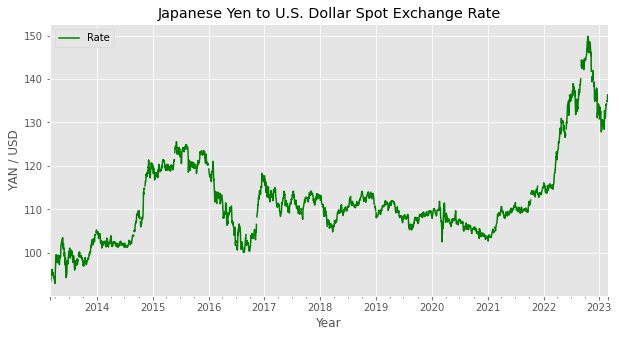

In [59]:
plt.style.use('ggplot')
ax = exchange.plot(color='green', grid=True, figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('YAN / USD')
ax.set_title('Japanese Yen to U.S. Dollar Spot Exchange Rate') 

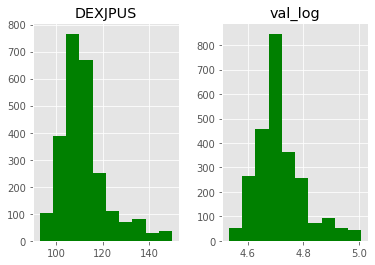

In [77]:
exchange2 = exchange
exchange2['val_log'] = np.log(exchange)
exchange.hist(color='green')
plt.show()

## Imputação / Interpolação de Valores
Como visto anteriormente no gráfico, e na tabela descritiva do _info()_, existem valores nulos, pelo que, neste passo são introduzidos. - ver / mudar -

In [60]:
### impute missing values with different methods

## impute mean
exchange= exchange.assign(FillMean=exchange.Rate.fillna(exchange.Rate.mean()))

## impute median
#df = df.assign(FillMedian=df.GDP.fillna(df.GDP.median()))

## linear interpolation
exchange = exchange.assign(InterpolateLinear=exchange.Rate.interpolate(method='linear'))

##cubic spline interpolation
# df = df.assign(InterpolateCubic=df.GDP.interpolate(method='cubic'))

## impute with the next value 
exchange = exchange.assign(FillF=exchange.Rate.fillna(method='ffill'))

## impute with the previous value
# df = df.assign(FillF=df.GDP.fillna(method='bfill'))

In [61]:
print(list(exchange)[1:])

['FillMean', 'InterpolateLinear', 'FillF']


In [62]:
## Scoring the results and see which is better

from sklearn.metrics import r2_score

results = [(method, r2_score(exchange.Rate, exchange[method])) for method in list(exchange)[1:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

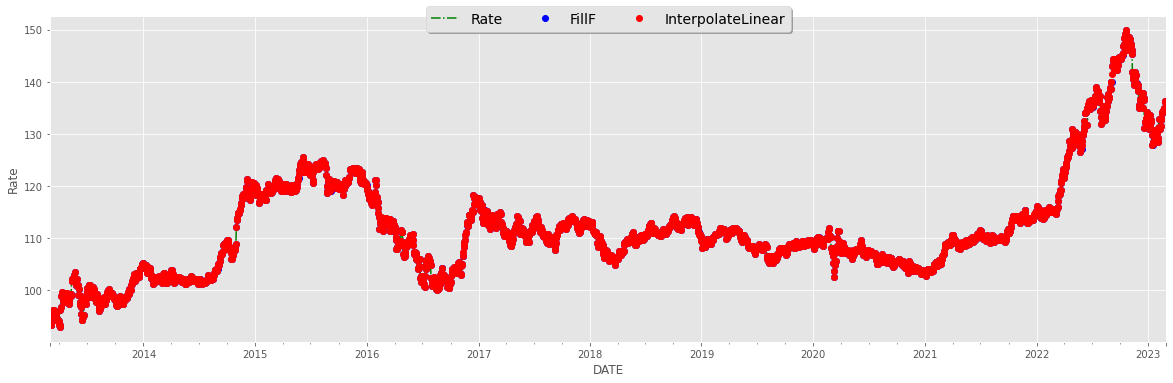

In [63]:
### plot the data after imputation

final_df= exchange[['Rate', 'FillF', 'InterpolateLinear']]
final_df.plot(style=['g-.', 'bo', 'ro'], figsize=(20,6));
plt.ylabel('Rate');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, ncol=5, prop={'size': 14} );

In [64]:
# Retain only the column with best interpolation
exchange = exchange.drop(columns=[col for col in exchange.columns if col != 'InterpolateLinear'])
exchange = exchange.rename(columns={'InterpolateLinear':'Rate'})

## Mudança de frequência temporal para Mensal

In [65]:
exchange_month = exchange.resample(rule='MS').mean()
exchange_month.head()

,Rate
DATE,
2013-03-01,94.770000
2013-04-01,97.758182
2013-05-01,100.945000
2013-06-01,97.235000
2013-07-01,99.703478


Text(0.5, 1.0, 'Japanese Yen to U.S. Dollar Spot Exchange Rate')

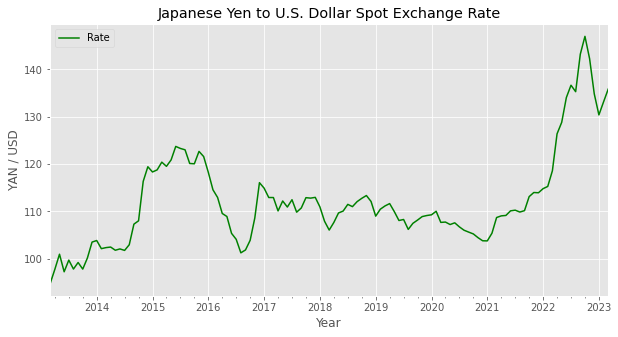

In [79]:
plt.style.use('ggplot')
ax = exchange_month.plot(color='green', grid=True, figsize=(10,5))
ax.set_xlabel('Year')
ax.set_ylabel('YAN / USD')
ax.set_title('Japanese Yen to U.S. Dollar Spot Exchange Rate') 

## Divisão Treino/Teste

In [66]:
split = round(len(exchange)*0.9)
exch_train, exch_test = exchange[0:split], exchange[split:]

In [67]:
exch_train.head()

,Rate
DATE,
2013-03-01,93.38
2013-03-04,93.32
2013-03-05,93.39
2013-03-06,93.64
2013-03-07,95.00


## Verificação das componentes de Tendência e Sazonalidade

<Axes: xlabel='DATE', ylabel='Resid'>

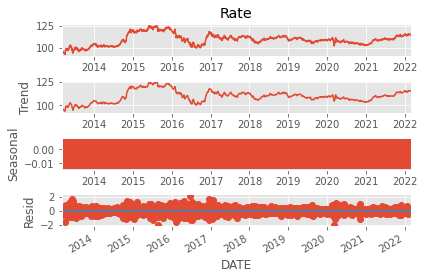

In [71]:
# proced with the time series decomposition
result=seasonal_decompose(exch_train['Rate'], model='additive')

# plot time series component
result.plot()

# plot only the seasonal component
result.seasonal.plot()

In [74]:
test1 = adfuller(exch_train)
print("p-value =", test1[1])

if test1[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.08918351681593195
We do not reject the H0: non-stationary time series <-> we have a unit root
